In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datetime import datetime
import numpy as np

$Kernel Receptive = ((Filter Size \; – \; 1) \times Dilation Factor + 1)$

$Output Size = \frac{(Input Size \; – \; Kernel Receptive \; + \; 2 \times Padding)}{Stride} + 1$

Trying to $Output Size = Input Size$ when $stride=1 \; \; \rightarrow \;\; Input Size = \frac{(Input Size \; – \; Kernel Receptive \; + \; 2 \times Padding)}{1} + 1$

$\rightarrow Input Size = \frac{(Input Size \; – \; Kernel Receptive \; + \; 2 \times Padding)}{1} + 1$

$\rightarrow 2 \times Padding = Kernel Receptive - 1$

$\rightarrow 2 \times Padding = ((Filter Size \; – \; 1) \times Dilation Factor + 1) - 1$

$\rightarrow Padding = \frac{(Filter Size \; – \; 1) \times Dilation Factor}{2} $

In [2]:
class MaskedConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, mask, dilation=1):
        super().__init__()

        kernel_size = (mask.shape[0], mask.shape[1])   
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)]) # See Equations above

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)

        self.register_buffer('mask', mask)
    
    def forward(self, x):
        self.conv.weight.data *= self.mask

        return self.conv(x)

torch.Size([3, 3])


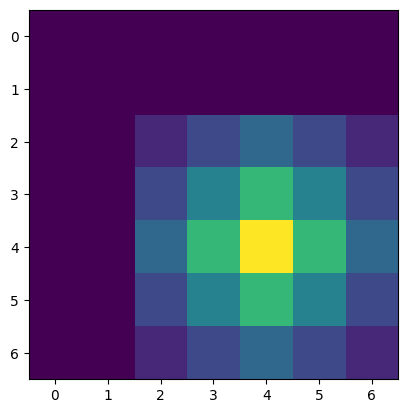

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=3, stride=1),
    nn.Conv2d(1, 1, kernel_size=3, stride=1),
)

for n in net:
    n.weight.data.fill_(1)
    n.bias.data.fill_(0)

a = torch.zeros(7, 7)
a.requires_grad_()
b = net(a[None, None, :, :])[0, 0]
print(b.shape)

i, j = 2, 2
loss = b[i, j].sum()
loss.backward(retain_graph=True)
plt.imshow(a.grad);

torch.Size([11, 11])


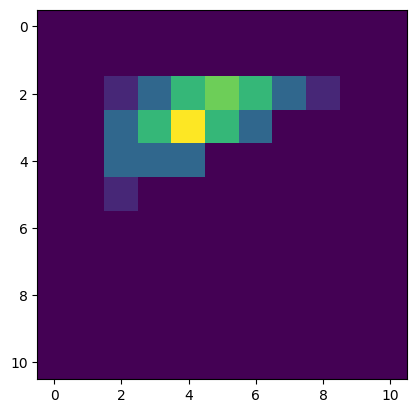

In [4]:
mask = torch.tensor([
    [1, 1, 1],
    [1, 0, 0],
    [0, 0, 0],
])
net = nn.Sequential(
    MaskedConvolution(1, 1, mask),
    MaskedConvolution(1, 1, mask),
    MaskedConvolution(1, 1, mask),
)

for n in net:
    n.conv.weight.data.fill_(1)
    n.conv.bias.data.fill_(0)

a = torch.zeros(11, 11)
a.requires_grad_()
b = net(a[None, None, :, :])[0, 0]
print(b.shape)

i, j = 5, 5
loss = b[i, j].sum()
loss.backward(retain_graph=True)
plt.imshow(a.grad);

In [5]:
class VerticalStackConvolusion(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, mask_center=False):
        mask = torch.zeros(kernel_size, kernel_size)
        mask[:kernel_size//2] = 1
        if not mask_center:
            mask[kernel_size//2] = 1
        
        super().__init__(in_channels, out_channels, mask, dilation)
    

class HorizontalStackConvolusion(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, mask_center=False):
        mask = torch.zeros(1, kernel_size)
        mask[0, :kernel_size//2] = 1
        if not mask_center:
            mask[0, kernel_size//2] = 1
        
        super().__init__(in_channels, out_channels, mask, dilation)

tmp = VerticalStackConvolusion(1, 1, 3, mask_center=False)
print(tmp.mask)
tmp = VerticalStackConvolusion(1, 1, 3, mask_center=True)
print(tmp.mask)
print("-"*30)
tmp = HorizontalStackConvolusion(1, 1, 3, mask_center=False)
print(tmp.mask)
tmp = HorizontalStackConvolusion(1, 1, 3, mask_center=True)
print(tmp.mask)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])
------------------------------
tensor([[1., 1., 0.]])
tensor([[1., 0., 0.]])


In [6]:
# mask = torch.tensor([
#     [1, 1, 1],
#     [1, 0, 0],
#     [0, 0, 0],
# ])
# net = nn.Sequential(
#     MaskedConvolution(1, 1, mask),
#     MaskedConvolution(1, 1, mask),
#     MaskedConvolution(1, 1, mask),
# )

# for n in net:
#     n.conv.weight.data.fill_(1)
#     n.conv.bias.data.fill_(0)

# a = torch.zeros(11, 11)
# a.requires_grad_()
# b = net(a[None, None, :, :])[0, 0]
# print(b.shape)

# i, j = 2, 2
# loss = b[i, j].sum()
# loss.backward(retain_graph=True)
# plt.imshow(a.grad);

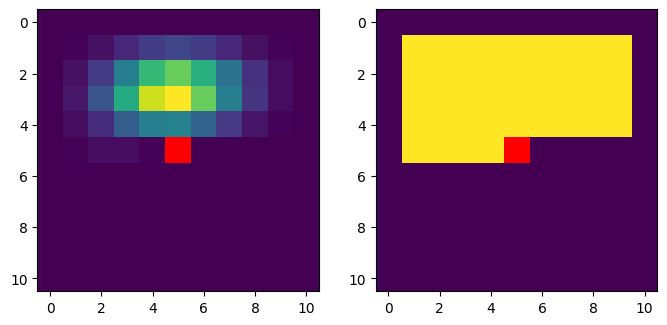

In [7]:
input_img = torch.zeros(11, 11)[None, None, :, :]
input_img.requires_grad_()

vert_conv = VerticalStackConvolusion(1, 1, 3, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(input_img)

horiz_conv = HorizontalStackConvolusion(1, 1, 3, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(input_img)


horiz_conv = HorizontalStackConvolusion(1, 1, 3, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VerticalStackConvolusion(1, 1, 3, mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)

for i in range(3):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img

i, j = 5, 5
loss = horiz_img[0, 0, i, j].sum()
loss.backward(retain_graph=True)
img_grads = input_img.grad.abs()
input_img.grad.fill_(0)

x = img_grads[0, 0]

center_pixel = torch.zeros(input_img.shape[-2:] + (4,))
center_pixel[i, j] = torch.tensor([1., 0., 0., 1.])

_, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(x)
x[x > 0] = x.max()
axs[1].imshow(x)
for i in range(2):
    axs[i].imshow(center_pixel)
plt.show()

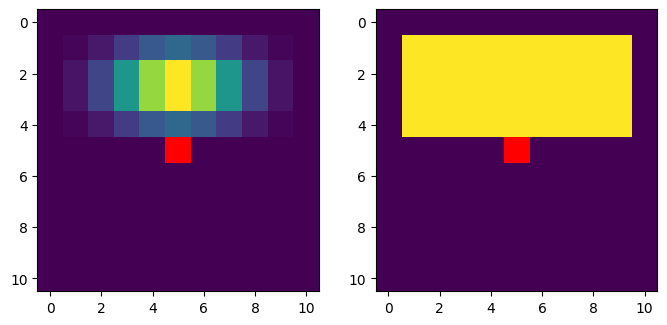

In [8]:
i, j = 5, 5
loss = vert_img[0, 0, i, j].sum()
loss.backward(retain_graph=True)
img_grads = input_img.grad.abs()
input_img.grad.fill_(0)

x = img_grads[0, 0]

center_pixel = torch.zeros(input_img.shape[-2:] + (4,))
center_pixel[i, j] = torch.tensor([1., 0., 0., 1.])

_, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(x)
x[x > 0] = x.max()
axs[1].imshow(x)
for i in range(2):
    axs[i].imshow(center_pixel)
plt.show()

![](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/PixelCNN_GatedConv.svg)

In [9]:
class GatedMaskedConv(nn.Module):
    def __init__(self, in_channels, dilation=1):
        super().__init__()

        self.conv_vertical = VerticalStackConvolusion(in_channels, in_channels*2, dilation=dilation)
        self.conv_horizontal = HorizontalStackConvolusion(in_channels, in_channels*2, dilation=dilation)

        self.conv_vertical_to_horizontal = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.conv_horizontal_trans = nn.Conv2d(in_channels, in_channels, kernel_size=1)
    
    def forward(self, v_stack, h_stack):
        v_stack_combined = self.conv_vertical(v_stack)
        v_stack_1, v_stack_2 = torch.chunk(v_stack_combined, 2, 1)
        v_stack_output = torch.tanh(v_stack_1) * torch.sigmoid(v_stack_2)

        h_stack_combined = self.conv_horizontal(h_stack) + self.conv_vertical_to_horizontal(v_stack_combined)
        h_stack_1, h_stack_2 = torch.chunk(h_stack_combined, 2, 1)
        h_stack_output = h_stack + self.conv_horizontal_trans(torch.tanh(h_stack_1) * torch.sigmoid(h_stack_2))

        return v_stack_output, h_stack_output


a, b = GatedMaskedConv(1)(torch.randn(1, 1, 20, 20), torch.randn(1, 1, 20, 20))
a.shape, b.shape

(torch.Size([1, 1, 20, 20]), torch.Size([1, 1, 20, 20]))

In [10]:
class PixelCNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, input_transform):
        super().__init__()

        self.input_transform = input_transform

        self.starting_conv_vertical = VerticalStackConvolusion(in_channels, hidden_channels, mask_center=True)
        self.starting_conv_horizontal = HorizontalStackConvolusion(in_channels, hidden_channels, mask_center=True)

        self.gated_masked_conv_layers = nn.ModuleList([
            GatedMaskedConv(hidden_channels),
            GatedMaskedConv(hidden_channels, dilation=2),
            GatedMaskedConv(hidden_channels),
            GatedMaskedConv(hidden_channels, dilation=4),
            GatedMaskedConv(hidden_channels),
            GatedMaskedConv(hidden_channels, dilation=2),
            GatedMaskedConv(hidden_channels),
        ])

        self.last_conv = nn.Conv2d(hidden_channels, in_channels*256, 1)

    def forward(self, x):
        x = self.input_transform(x)

        v_stack = self.starting_conv_vertical(x)
        h_stack = self.starting_conv_horizontal(x)

        for gated_masked_conv in self.gated_masked_conv_layers:
            v_stack, h_stack = gated_masked_conv(v_stack, h_stack)
        
        B, C, H, W = x.shape
        output = self.last_conv(F.elu(h_stack)).reshape(B, 256, C, H, W)

        return output


PixelCNN(in_channels=1, hidden_channels=20, input_transform=transforms.Lambda(lambda x: x))(torch.randn(1, 1, 28, 28)).shape

torch.Size([1, 256, 1, 28, 28])

In [11]:
def visualize_receptive_field(model, input_size, i, j):
    input_img = torch.zeros(input_size, requires_grad=True)
    output = model(input_img)

    loss = output[(0,) * (output.ndim - 2) + (i, j)].sum()
    loss.backward(retain_graph=True)

    img_grads = input_img.grad.abs()

    x = img_grads[0, 0]

    center_pixel = torch.zeros(input_img.shape[-2:] + (4,))
    center_pixel[i, j] = torch.tensor([1., 0., 0., 1.])

    _, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(x)
    x[x > 0] = x.max()
    axs[1].imshow(x)
    for i in range(2):
        axs[i].imshow(center_pixel)
    plt.show()

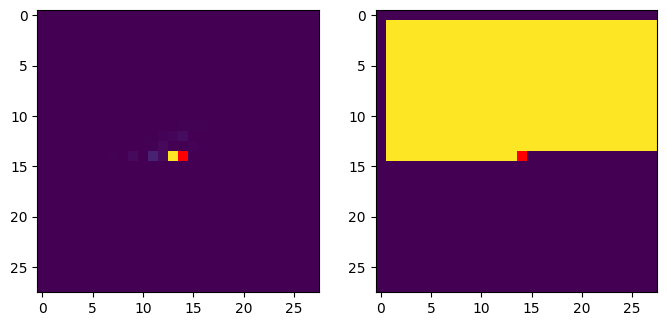

In [13]:
visualize_receptive_field(PixelCNN(in_channels=1, hidden_channels=20, input_transform=transforms.Lambda(lambda x: x)), (1, 1, 28, 28), 14, 14)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [15]:
model = PixelCNN(
    in_channels=1,
    hidden_channels=20,
    input_transform=transforms.Lambda(lambda x: (x.float() / 255.0) * 2 - 1)
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.98)

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).type(torch.long))
])
dataset = torchvision.datasets.MNIST('../data/mnist/', train=True, transform=transform, download=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
val_dataset = torchvision.datasets.MNIST('../data/mnist/', train=False, transform=transform, download=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [17]:
epochs = 300
train_loss_arr, val_loss_arr = [], []

for epoch in range(epochs):
    train_loss = 0.
    model.train()
    for images, _ in dataloader:
        images = images.to(device)
        
        output = model(images)

        nll = F.cross_entropy(output, images, reduction='none')
        bpd = nll.mean(dim=[1, 2, 3]) * np.log2(np.exp(1))
        loss = bpd.mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += images.shape[0] * loss.item()
    scheduler.step()

    val_loss = 0.
    model.eval()
    for images, _ in val_dataloader:
        images = images.to(device)
        
        output = model(images)

        nll = F.cross_entropy(output, images, reduction='none')
        bpd = nll.mean(dim=[1, 2, 3]) * np.log2(np.exp(1))
        loss = bpd.mean()

        val_loss += images.shape[0] * loss.item()

    train_loss /= len(dataloader.dataset)
    val_loss /= len(val_dataloader.dataset)

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    print(f'[{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}] [Epoch {epoch:3d}] Train Loss: {train_loss:.5f}  -  Validation Loss: {val_loss:.5f}')


[2023-06-14 17:06:28] [Epoch   0] Train Loss: 1.39796  -  Validation Loss: 1.18454
[2023-06-14 17:07:06] [Epoch   1] Train Loss: 1.16788  -  Validation Loss: 1.14894
[2023-06-14 17:07:41] [Epoch   2] Train Loss: 1.14536  -  Validation Loss: 1.13264
[2023-06-14 17:08:15] [Epoch   3] Train Loss: 1.13276  -  Validation Loss: 1.12243
[2023-06-14 17:08:49] [Epoch   4] Train Loss: 1.12384  -  Validation Loss: 1.11513
[2023-06-14 17:09:23] [Epoch   5] Train Loss: 1.11611  -  Validation Loss: 1.10613
[2023-06-14 17:09:58] [Epoch   6] Train Loss: 1.10660  -  Validation Loss: 1.09396
[2023-06-14 17:10:33] [Epoch   7] Train Loss: 1.09643  -  Validation Loss: 1.08309
[2023-06-14 17:11:06] [Epoch   8] Train Loss: 1.08693  -  Validation Loss: 1.07722
[2023-06-14 17:11:40] [Epoch   9] Train Loss: 1.07671  -  Validation Loss: 1.06654
[2023-06-14 17:12:13] [Epoch  10] Train Loss: 1.06938  -  Validation Loss: 1.05377
[2023-06-14 17:12:46] [Epoch  11] Train Loss: 1.05657  -  Validation Loss: 1.04081
[202

In [18]:
torch.save(model.state_dict(), 'pixelcnn.pth')

# model = PixelCNN(
#     in_channels=1,
#     hidden_channels=20,
#     input_transform=transforms.Lambda(lambda x: (x.float() / 255.0) * 2 - 1)
# )
# model.load_state_dict(torch.load('model.pth'))
# model = model.to(device)

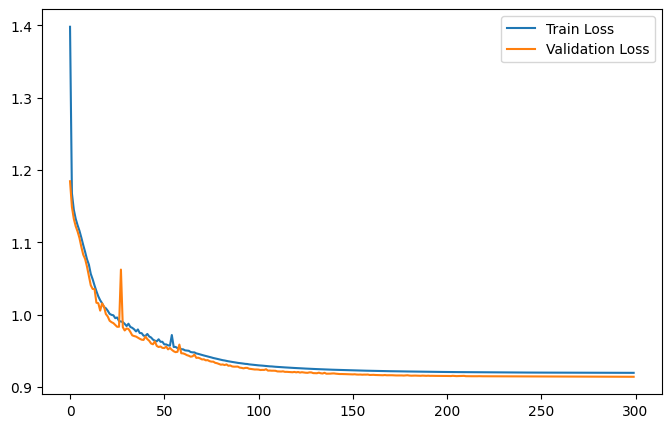

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.legend(['Train Loss', 'Validation Loss'])
plt.show();

In [20]:
def sample_image(model, img_shape, device):
    img = torch.zeros(img_shape).to(device)

    _, C, H, W = img_shape
    for h in range(H):
        for w in range(W):
            for c in range(C):
                pred = model(img[:, :, :h+1, :])
                prob = F.softmax(pred[:, :, c, h, w], dim=-1)
                img[:, c, h, w] = torch.multinomial(prob, num_samples=1).squeeze(-1)
    
    return img

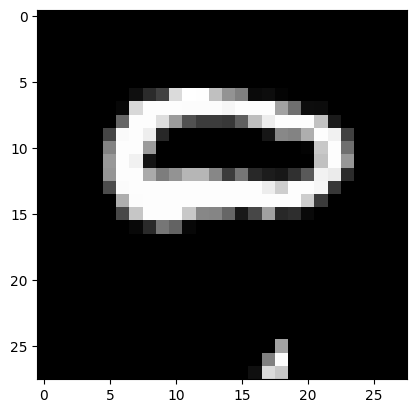

In [21]:
model.eval()
sample = sample_image(model, (1, 1, 28, 28), device)
plt.imshow(sample[0].detach().cpu().permute(1, 2, 0), cmap='gray');

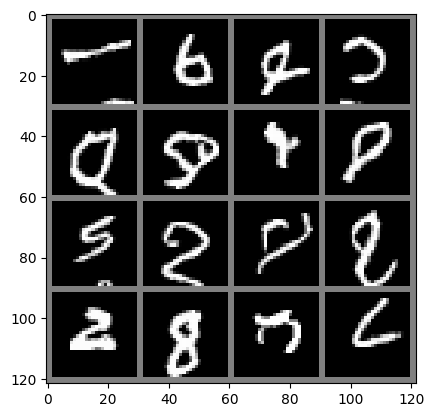

In [22]:
plt.imshow(
    torchvision.utils.make_grid(
        sample_image(model, (16, 1, 28, 28), device).detach().cpu(),
        nrow=4,
        pad_value=128
    ).permute(1, 2, 0).clamp(0, 255).type(torch.int)
);

In [24]:
def autocomplete_img(model, img):
    _, C, H, W = img.shape
    for h in range(H):
        for w in range(W):
            for c in range(C):
                if (img[:, c, h, w] != -1).all().item():
                    continue
                pred = model(img[:, :, :h+1, :])
                prob = F.softmax(pred[:, :, c, h, w], dim=-1)
                img[:, c, h, w] = torch.multinomial(prob, num_samples=1).squeeze(-1)
    
    return img

In [25]:
original_images = torch.stack([dataset[i][0] for i in range(10)])

incompleted_images = original_images.clone()
incompleted_images[:, :, 10:, :] = -1

completed_images = autocomplete_img(model, incompleted_images.to(device))

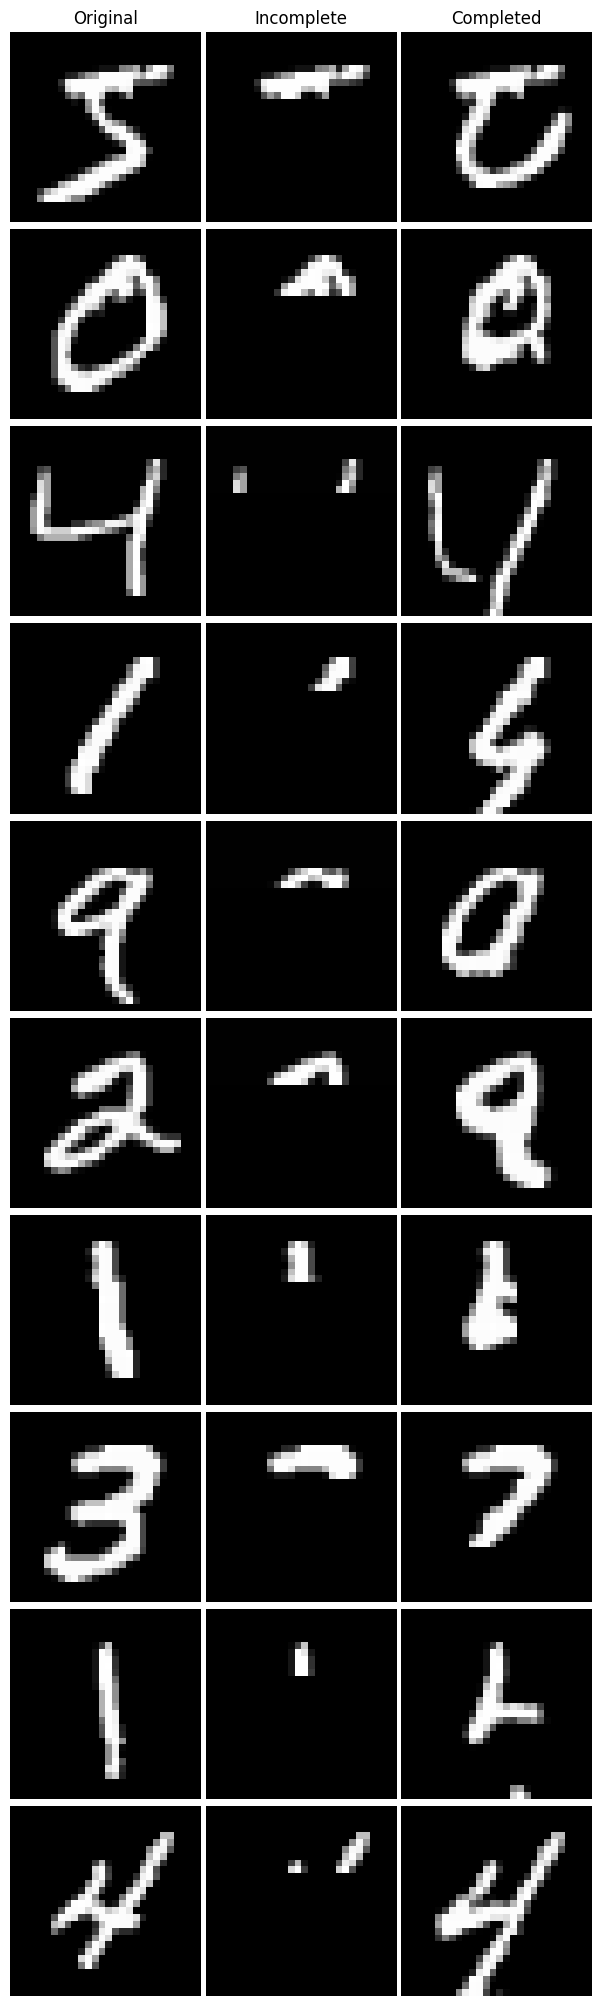

In [27]:
N = completed_images.shape[0]
fig, axs = plt.subplots(N, 3, figsize=(6, 2*N))
axs[0][0].set_title("Original")
axs[0][1].set_title("Incomplete")
axs[0][2].set_title("Completed")
for i in range(N):
    for j in range(3):
        axs[i][j].axis('off')
    axs[i][0].imshow(original_images[i].permute(1, 2, 0), cmap='gray');
    axs[i][1].imshow(incompleted_images[i].permute(1, 2, 0), cmap='gray');
    axs[i][2].imshow(completed_images[i].detach().cpu().permute(1, 2, 0), cmap='gray')
plt.tight_layout(pad=0.5);